In [201]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

plt.style.use("ggplot")
np.set_printoptions(suppress=True)

# Load Data
Dataset comes from **Time Series Data Library**. It's monthly milk production pounds per cow from 1962 Jan to 1975 Dec. 

In [63]:
data = pd.read_csv('monthly-milk-production-pounds-p.csv',index_col = 'Month',parse_dates= True, names = ['Month','Milk Production'],skiprows=1)
data.head()

,Milk Production
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


([<matplotlib.axis.XTick at 0x22b806070b8>,
 <a list of 8 Text xticklabel objects>)

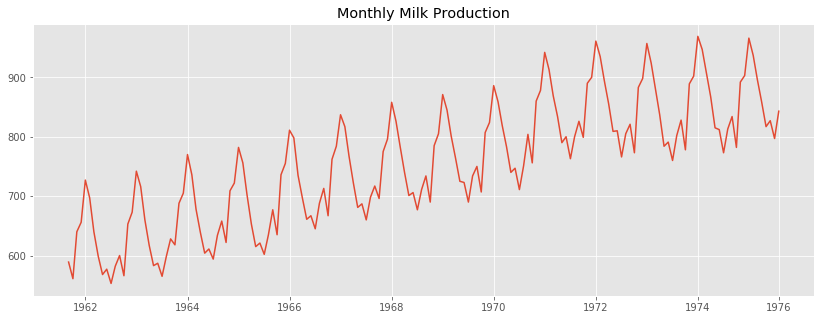

In [280]:
plt.figure(figsize=(14,5))
plt.plot(data)
plt.title('Monthly Milk Production')
plt.xticks(['1962-05','1964-05', '1966-05','1968-05', '1970-05','1972-05','1974-05','1975-12'],
           [1962,1964,1966,1968,1970,1972,1974,1976])

# Stationary Check
## Visulization
There are three creterias for time series to be stable:
1. Stationary Variance
2. Stationary Mean
3. Stationary Covariance

In [286]:
def plotRolling(ts,window):
    rollingMean = ts.rolling(window=window).mean()
    rollingStd = ts.rolling(window=window).std()
    plt.figure(figsize=(14,5))
    ax1 = plt.subplot(2,1,1)
    plt.plot(rollingMean,color = 'Red',label = 'Rolling Mean')
    plt.plot(ts,color = 'Blue',label = 'Original')
    plt.legend()
    
    plt.subplot(2,1,2,sharex = ax1)
    plt.plot(rollingStd,color = 'Black',label = 'Rolling Std')
    plt.legend()

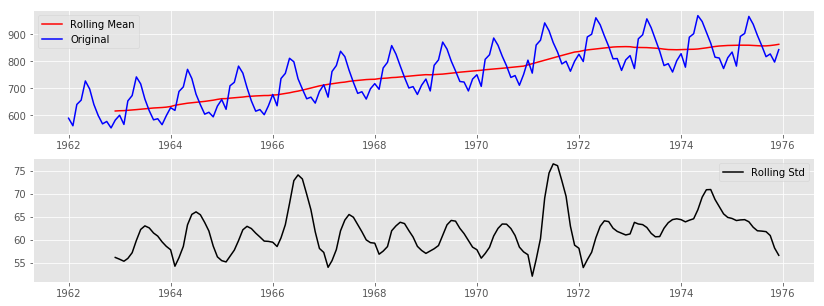

In [287]:
plotRolling(data['Milk Production'],12)

## Dickey-Fuller Test - ADF Test

In [288]:
from statsmodels.tsa.stattools import adfuller
def dfTest(ts):
    dftest = adfuller(ts)
    output = pd.Series(dftest[:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        output[f'Critical Value ({key})'] = value 
    print(output)

In [289]:
dfTest(data['Milk Production'])

Test Statistic                  -1.303812
p-value                          0.627427
#Lags Used                      13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


The lowerp-value the  more stationary series. In most case, p-value is required to be less than 0.05.

## Conclusion
Original time series is not stationary.

# Make Time Series Stationary

There are 2 major reasons behind non-stationary time series:
1. Trend - varying mean over time.
2. Seasonality - variations at specific time-frames.

## Tricks 1 - Transformation
Take a log on time series data which penalize higher values more than smaller values. 

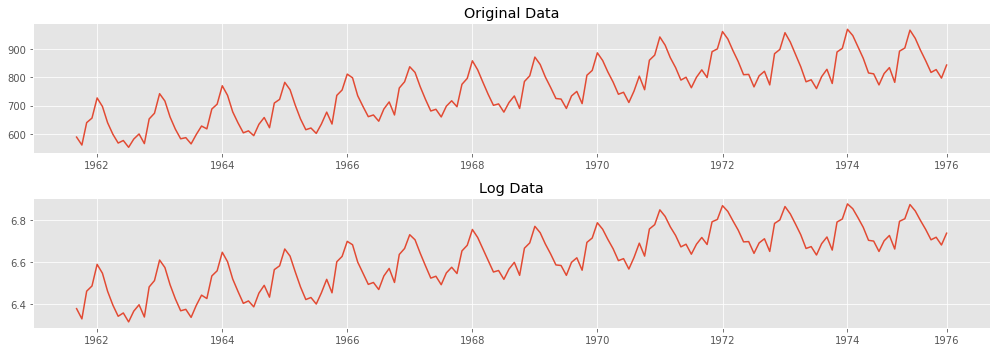

In [295]:
plt.figure(figsize=(14,5))
ax1 = plt.subplot(211)
plt.plot(data)
plt.title('Original Data')
plt.xticks(['1962-05','1964-05', '1966-05','1968-05', '1970-05','1972-05','1974-05','1975-12'],
           [1962,1964,1966,1968,1970,1972,1974,1976])
ax2 = plt.subplot(212, sharex = ax1)
plt.title('Log Data')
logdata = np.log(data)
plt.plot(logdata)
plt.xticks(['1962-05','1964-05', '1966-05','1968-05', '1970-05','1972-05','1974-05','1975-12'],
           [1962,1964,1966,1968,1970,1972,1974,1976])
plt.tight_layout() #Without this, the title will overlap the first plot x axis

In [291]:
dfTest(logdata['Milk Production'])

Test Statistic                  -1.754797
p-value                          0.403123
#Lags Used                      13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


## Tricks 2 - Elimilate Trend
The first step is modeling the trend, there are several technics:
    1. Aggregation -  taking average for a time period
    2. Smoothing - taking rolling averages
    3. Polynomial Fitting - fit a regression model
### Aggregation

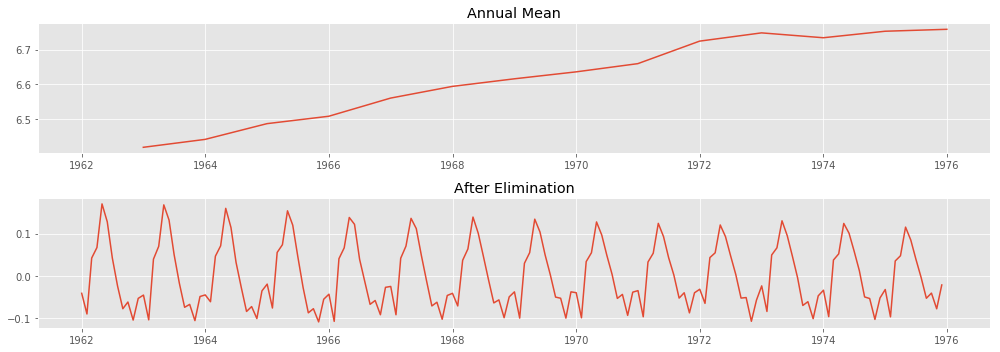

In [296]:
plt.figure(figsize=(14,5))
ax1 = plt.subplot(211)
plt.plot(logdata.resample('y').mean())
plt.title('Annual Mean')
ax2 = plt.subplot(212,sharex = ax1)
plt.tight_layout()
#plt.plot(logdata - logdata.resample('y').mean())
annualMean = logdata.resample('y').mean()
plt.title('After Elimination')
a = annualMean['Milk Production'].repeat(12)
a.index = logdata.index
plt.plot(logdata['Milk Production'] - a)
plt.tight_layout()

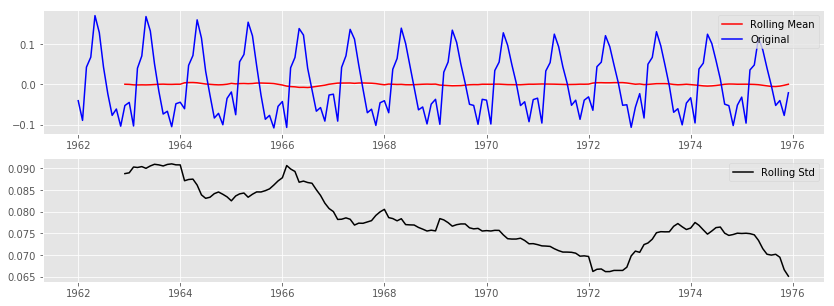

In [293]:
plotRolling(logdata['Milk Production'] - a,12)

In [294]:
dfTest(logdata['Milk Production'] - a)

Test Statistic                  -4.896971
p-value                          0.000035
#Lags Used                      13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


### Smoothing

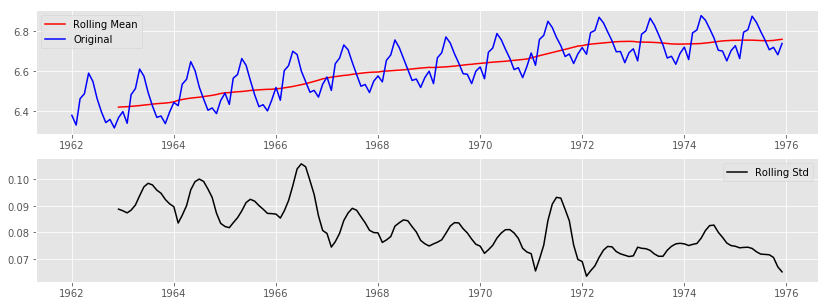

In [297]:
logts = logdata['Milk Production']
plotRolling(logts,12)

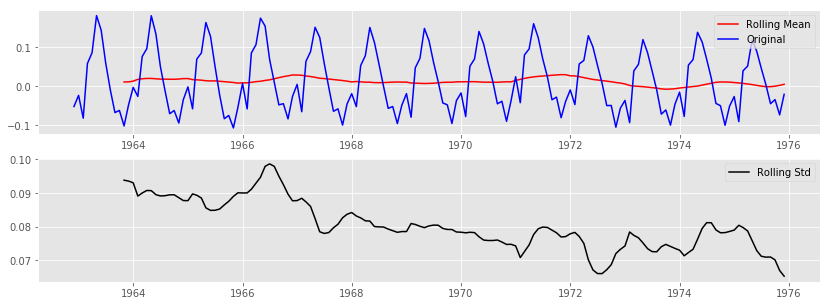

In [298]:
movingts = logts.rolling(window=12).mean()

logts_moving_diff = logts - movingts
plotRolling(logts_moving_diff,12)

In [299]:
logts_moving_diff = logts_moving_diff.dropna()
dfTest(logts_moving_diff)

Test Statistic                  -3.321011
p-value                          0.013965
#Lags Used                      13.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64


### Regression

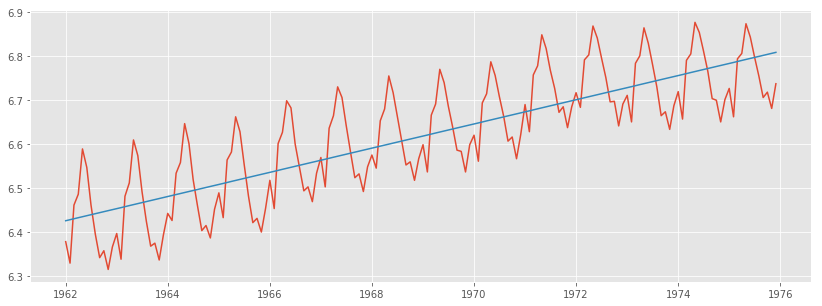

In [301]:
from sklearn import linear_model
plt.figure(figsize=(14,5))
regr = linear_model.LinearRegression()
regr.fit(np.arange(len(logts)).reshape(-1,1),logts.values.reshape(-1,1))
plt.plot(logts)
predict = regr.predict(np.arange(len(logts)).reshape(-1,1)).reshape(-1)
predictts = pd.Series(predict,index=logts.index)
plt.plot(predictts)

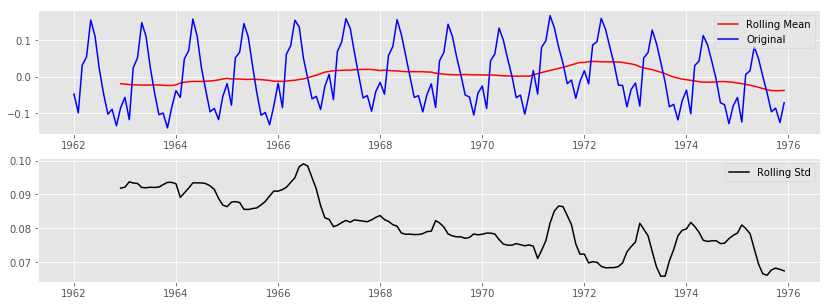

In [302]:
regression_diff = logts-predictts
plotRolling(regression_diff,12)

In [303]:
dfTest(regression_diff)

Test Statistic                  -2.403137
p-value                          0.140853
#Lags Used                      13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


## Tricks 3 - Handling Trend and Seasonality

There are mainly two approach:

    1.Differencing
    2.Decomposition
### Differencing

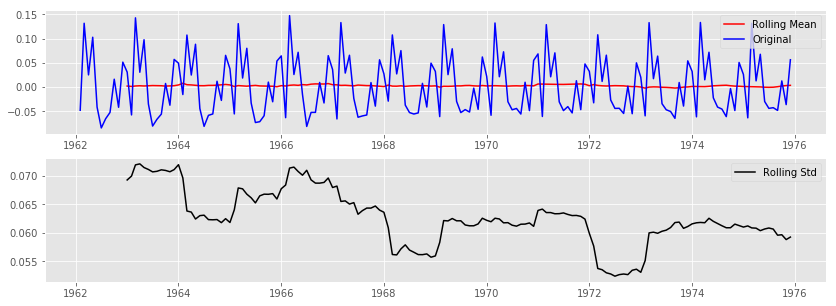

In [304]:
ts_log_diff = logts - logts.shift(1)
plotRolling(ts_log_diff,12)

In [270]:
dfTest(ts_log_diff.dropna())

Test Statistic                  -2.906633
p-value                          0.044582
#Lags Used                      12.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


### Decomposing

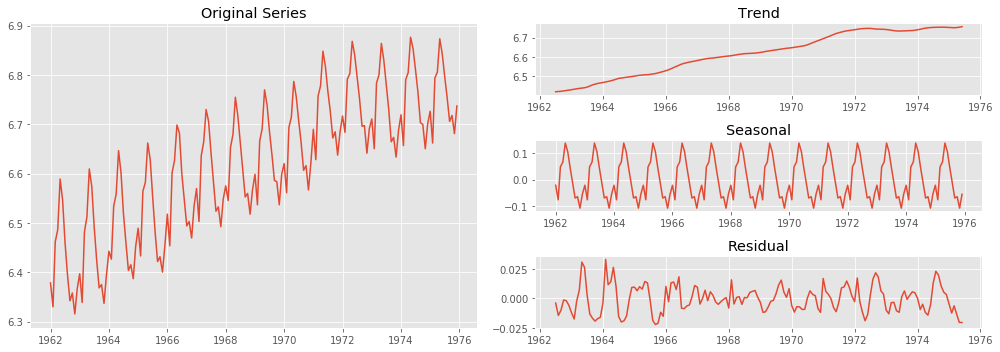

In [189]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(logts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.plot(logts)
plt.title('Original Series')

plt.subplot(322)
plt.plot(trend)
plt.title('Trend')
plt.subplot(324)
plt.plot(seasonal)
plt.title('Seasonal')
plt.subplot(326)
plt.plot(residual)
plt.title('Residual')
plt.tight_layout()

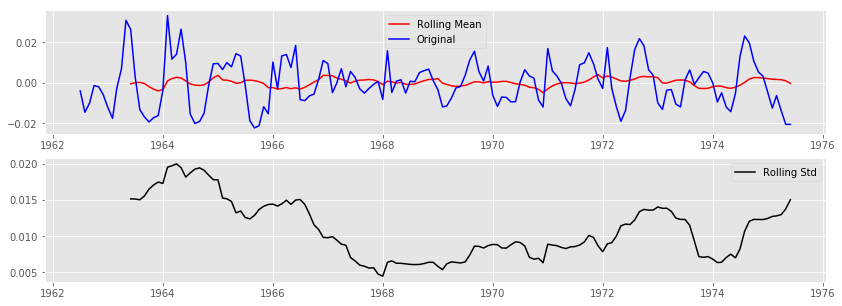

In [305]:
plotRolling(residual,12)

In [202]:
dfTest(residual.dropna())

Test Statistic                -7.924567e+00
p-value                        3.647860e-12
#Lags Used                     8.000000e+00
Number of Observations Used    1.470000e+02
Critical Value (1%)           -3.475637e+00
Critical Value (5%)           -2.881410e+00
Critical Value (10%)          -2.577365e+00
dtype: float64


# Time Series Modeling
## ACF and PACF

ACF measures the correlation between the time series and a lagged version of itself.

PACF measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. For example, ACF between $X_t$ and $X_{t-k}$ is not their pure correlation, since $X_t$ are also affected by $X_{t-1}, X_{t-2}...X_{t-k+1}$. PACF is the correlation which elimilate these affections.

In [210]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff.dropna(), nlags=20)
lag_pacf = pacf(ts_log_diff.dropna(), nlags=20,method = 'ols')

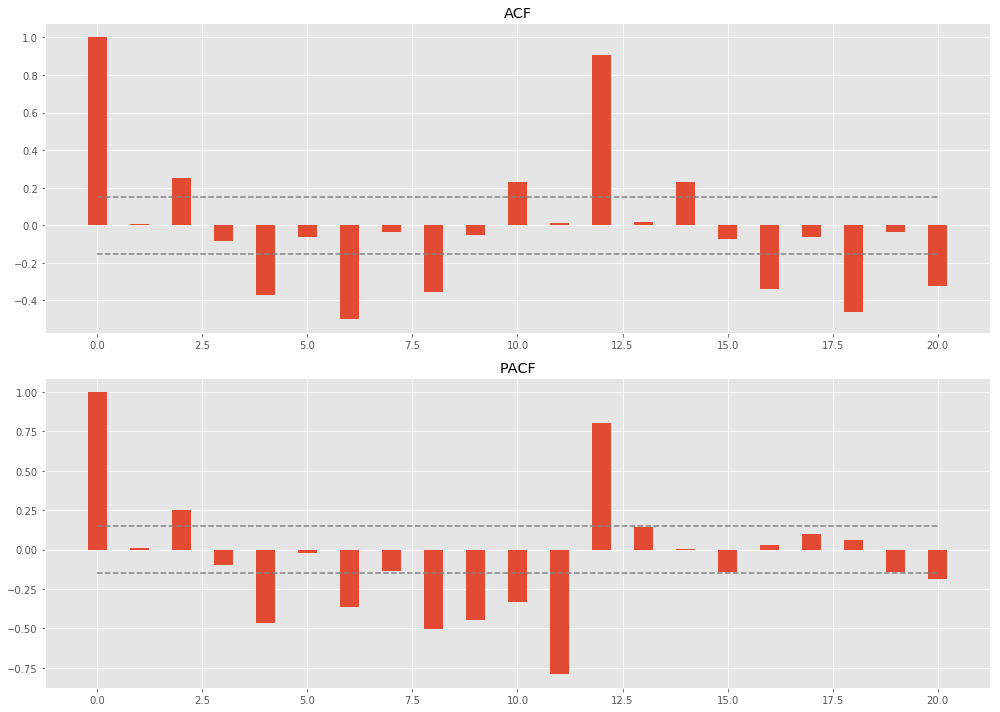

In [235]:
confidenceLevel = 1.96/np.sqrt(len(ts_log_diff)).repeat(21)

plt.figure(figsize=(14,10))

plt.subplot(211)
plt.bar(np.arange(21),lag_acf,0.45)
plt.plot(np.arange(21),confidenceLevel,'--',color = 'gray')
plt.plot(np.arange(21),-confidenceLevel,'--',color = 'gray')
plt.title('ACF')

plt.subplot(212)
plt.bar(np.arange(21),lag_pacf,0.45)
plt.plot(np.arange(21),confidenceLevel,'--',color = 'gray')
plt.plot(np.arange(21),-confidenceLevel,'--',color = 'gray')
plt.title('PACF')

plt.tight_layout()

## ARIMA Model

There are three parameters (p,d,q):

p is the lags of dependent variables. For example, if p = 2, then the predictors of $X_t$ is $X_{t-1}$ and $X_{t-2}$.

q is the lagged forcast errors.

d is the degree of difference.

### AR Model

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.5720')

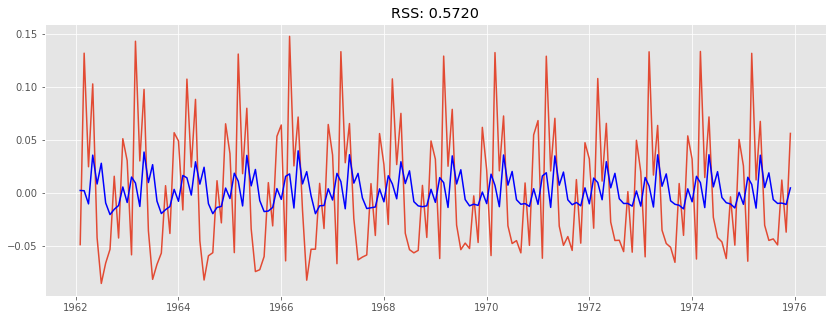

In [258]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log_diff.dropna(), order=(2, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.figure(figsize=(14,5))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff.dropna())**2))

### MA Model

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.5283')

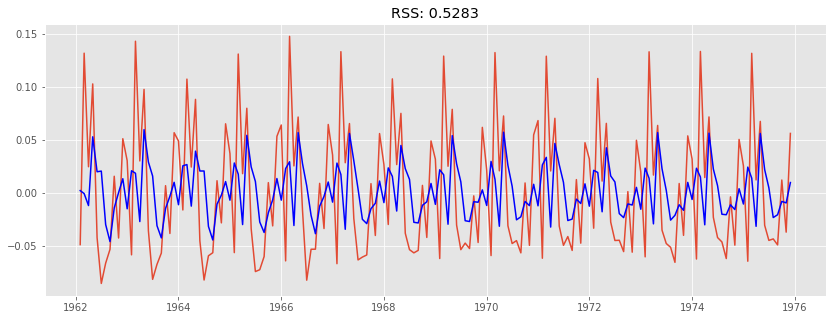

In [256]:
model = ARIMA(ts_log_diff.dropna(), order=(0, 0, 2))  
results_AR = model.fit(disp=-1)  
plt.figure(figsize=(14,5))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff.dropna())**2))

### ARMA Model

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.5365')

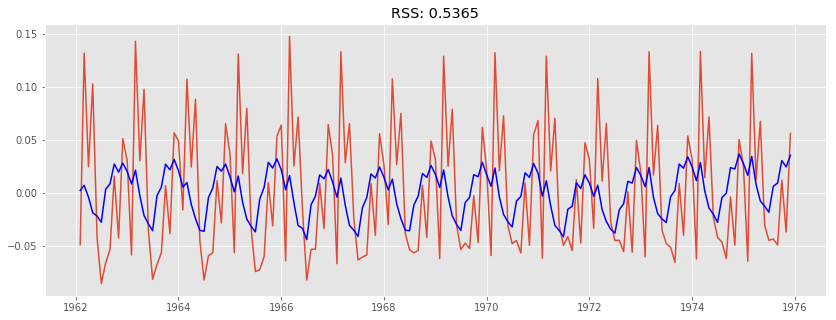

In [259]:
model = ARIMA(ts_log_diff.dropna(), order=(2, 0, 2))  
results_AR = model.fit(disp=-1)  
plt.figure(figsize=(14,5))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff.dropna())**2))

## Back to Original Scale

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


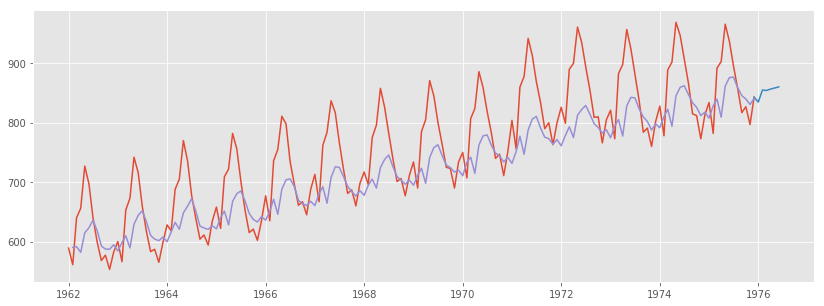

In [368]:
import datetime as dt

model = ARIMA(logts.dropna(), order=(1, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(logts.iloc[0], index=logts.index)
originalPredictions = np.exp(predictions_ARIMA_diff_cumsum+predictions_ARIMA_log)

forcast = results_ARIMA.forecast(steps = 6)[0]
forcast = np.insert(forcast,0,logts.iloc[-1])
dates = pd.date_range('1975-12-01','1976-6-30',freq = 'MS',closed = 'left')
forcastSeries = np.exp(pd.Series(forcast,index = dates))

plt.figure(figsize=(14,5))
plt.plot(data)
plt.plot(forcastSeries)
plt.plot(originalPredictions)

# Model Selection
## Information Creteria
As we increase the parameters in the model, the performance tends to be better, but we need to penalize the new parameters. There are two common infomation creteria AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion).

In [373]:
model = ARIMA(logts.dropna(), order=(1, 1, 2))  
results_ARIMA = model.fit(disp=-1)

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [374]:
print(pd.Series([results_ARIMA.aic,results_ARIMA.bic],index = ['AIC','BIC'],name='Information Creteria'))

AIC   -478.538868
BIC   -462.948899
Name: Information Creteria, dtype: float64
